# Guilherme Kinzel
### Pair Trading - Básico

Neste notebook faremos uma breve explicação matemática com programação em R para desmitificar o _pair trading_

Versão: 28JUL2020

Material de estudo

### Tópicos

* Breve explicação
* Quais seriam os melhores candidatos à pair trading?
* Cointegração
* Cointegração vs Correlação
* Indo a fundo - Matemática

### Breve explicação

_Pair trading_ é um "arbitragem estatística", onde há um desvio estatístico de preço entre dois ativos que pretendemos explorar e que em todos os casos se encaixa na cesta de _trading_ de reversão à média. Em essência, o pair trading é acompanhar o _spread_ (ou diferencial) entre dois ativos e qualquer desvio significativo desta é dado como uma oportunidade de _trading_.

### Quais seriam os melhores candidatos à pair trading?

Aqueles que fundamentalmente tenham alguma razão para terem o _spread_ constante, e você acredite que poderá explorar uma possível reversão à média/estacionaridade. 

**Exemplo**

Um bom exemplo seria (Preço do Ouro) vs (Mina de Ouro). Qualquer desvio significativo do _spread_ como a (Mina de Ouro) subir muito e o (Preço do Ouro) cair muito seria algo intuitivamente estranho, pois: como a mina de ouro pode subir e o ouro não? Removendo variáveis discricionárias, é esperado que o _spread_ retorne à média, uma possível oportunidade de VENDER (Mina de Ouro) e COMPRAR (Preço do Ouro).

## Cointegração

Entretanto, precisamos de algo mais forte do que a intuição e análise de fundamentos para sabermos se o par é candidato para _trading_. Atualmente o teste mais comum para determinar se o par é bom ou não para _pair trading_ é a **cointegração**. Explicaremos com um exemplo:

**Exemplo**

Você sai com o seu cachorro com coleira para passear na rua. Ambos estão em _Random Walk_ (você decidiu sair com o cachorro após voltar do bar!), cada um vai para o caminho que quer. Quando você puxa o seu cachorro para próximo de si, é o **momento em que vocês dois estão cointegrados**. Perceba que a distância máxima entre você e o seu cachorro é limitada à extensão da coleira. Em termos de _trading_ a oportunidade é quando o cachorro está chegando próximo ao limite da coleira ou quando ele está muito próximo de você.



<img src="101016185-boy-walking-a-dog-on-the-leash.jpg" width="200" />

## Cointegração vs Correlação

**Correlação**: dois ativos (A e B) estão correlacionados quando A sobe e B sobe, ou vice-versa: quando A cai e B cai também.

**Cointegração**: quando existe uma combinação linear estacionária de variáveis não estacionárias (A e B)

É possível que A e B sejam correlacionados e não cointegrados, como também serem não correlacionados e cointegrados.


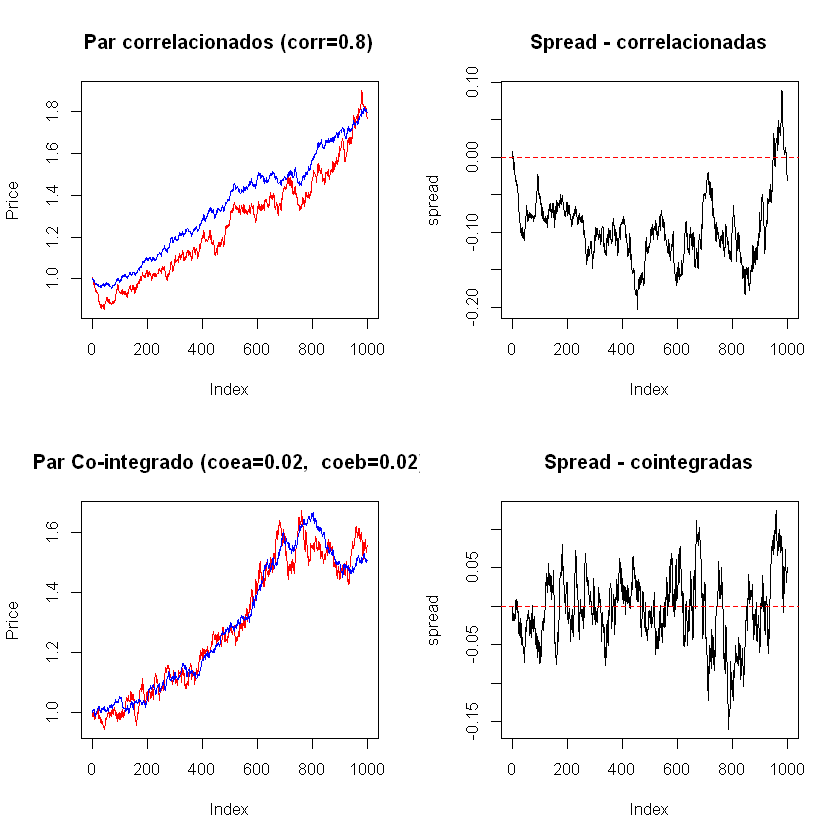

In [4]:
library(MASS)

#Code largely copied from http://quant.stackexchange.com/questions/1027/how-are-correlation-and-cointegration-related

set.seed(4)
#The input data
nsim <- 1000  #Number of data points
mu_a <- 0.0002  #Mu_a growth rate for stock a
sigma_a <- 0.010   #Sigma_a volatility for stock a
mu_b <- 0.0005  #Mu_a growth rate for stock a
sigma_b <- 0.005   #Sigma_a volatility for stock a
corxy <- 0.8    #Correlation coeficient for xy

#Calculate a correlated return series
#Build the covariance matrix and generate the correlated random results
covmat <- matrix(c(sigma_a^2, corxy*sigma_a*sigma_b, corxy*sigma_a*sigma_b, sigma_b^2), nrow=2)

res <- mvrnorm(nsim, c(mu_a, mu_b), covmat)    #Calculate multivariate normal distribution

path_a <- exp(cumsum(res[,1]))
path_b <- exp(cumsum(res[,2]))
spread <- path_a - path_b
#Set the plotting area to a 2 by 1 grid
par(mfrow = c(2, 2))
#Plot the two price series that have correlated returns
plot(path_a, main=paste0("Par correlacionados (corr=",corxy,")"), ylab="Price", type="l", col="red")
lines(path_b, col="blue")
plot(spread, type="l", main = "Spread - correlacionadas")
abline(h=0, col = 'red',lty=2)


##Cointegrated pair
#The input data
coea <- 0.0200    #Co-integration coefficient for x
coeb <- 0.0200    #Co-integration coefficient for y

#Generate the noise terms for x and y
rana <- rnorm(nsim, mean=mu_a, sd=sigma_a) #White noise for a
ranb <- rnorm(nsim, mean=mu_b, sd=sigma_b) #White noise for b

#Generate the co-integrated series x and y
a <- numeric(nsim)
b <- numeric(nsim)
a[1] <- 0
b[1] <- 0
for (i in 2:nsim) {
  #Logic here is that is b>a then we add on the difference so that
  #a starts to catch up with b, hence causing the spread to close
  a[i] <- a[i-1] + (coea * (b[i-1] - a[i-1])) + rana[i-1]
  b[i] <- b[i-1] + (coeb * (a[i-1] - b[i-1])) + ranb[i-1]
}

#Plot a and b as prices
ylim <- range(exp(a), exp(b))
path_a <- exp(a)
path_b <- exp(b)
spread <- path_a - path_b

plot(path_a, ylim=ylim, type="l", main=paste("Par Co-integrado (coea=",coea,",  coeb=",coeb,")", sep=""), ylab="Price", col="red")
lines(path_b, col="blue")

plot(spread,type="l", main = "Spread - cointegradas")
abline(h=0, col = 'red',lty=2)

O mais importante a se notar é nos gráficos do _spread_. Perceba que a média do _spread_ do cointegrado é bem próxima a zero.

## Indo a fundo - Matemática

Obs.: a parte mais complexa será abordada num outro Notebook com a utilização de pacotes de cointegração.

Vamos explorar cointegração com o movimento Browniano geométrico, também conhecido como geometric Brownian motion (GBM). O cerne da matemática abaixo é do valor esperado do _spread_ ser 0, ou:

$E_t[\Delta \text{Spread}]=0$

(em caso de dúvida, olhe os gráficos acima)

Em termos de _trading_ a oportunidade seria quando $|\Delta \text{Spread}|$ está muito alto relativamente - estas que podem ser feitas com desvio-padrão ($\sigma$).

Para isto iremos nos desbruçar no cálculo de outras equações, segue:

### Pensamento

Dado que o preço da ação em $t+T$ é:

$A_{t+T} = A_t + N(\mu_a T, \sigma_a \sqrt{T})$

Fazendo $\Delta A = A_{t+T} - A_t$ e o intervalo entre $T$ e $t$, $\Delta t = T-t$. 

$\Delta A = N(\mu_a \Delta t, \sigma_a \sqrt{\Delta t})$ (1)

Usaremos valor esperado:

$E_t[\Delta A] = \mu_a$

Ou seja, o valor esperado de cada passo em $t$ é de $\mu_a$. Em outras palavras, $A$ não é estacionário assumindo $\mu_a \neq 0$.

**Indo mais a fundo na cointegração**

A equação de spread de quantas ações de B para cada 1 de A é:

$\text{Spread} = A - n B$

Faremos a diferença de spread para usarmos com o intervalo (1)

$\Delta \text{Spread} = \Delta A - n \Delta B$

$\Delta \text{Spread} = N(\mu_a \Delta t, \sigma_a \sqrt{\Delta t})  - n \Delta N(\mu_b \Delta t, \sigma_b \sqrt{\Delta t})$

Mas nós desejamos buscar as premissas de estacionaridade, ou seja quando $E_t[\Delta \text{Spread}]=0$. Calculando o valor esperado:

$E_t[\Delta \text{Spread}] = \mu_a - n \mu_b$

Para $E_t[\Delta \text{Spread}]=0$, fazemos:

$\mu_a - n \mu_b = 0$

$n = \frac{\mu_a}{\mu_b}$

Ou seja, é estacionário se assumirmos que $n$ se mantém constante.

## Créditos:

http://www.eco.uc3m.es/~jgonzalo/teaching/EconometriaII/cointegration.htm

http://gekkoquant.com/2012/10/21/statistical-arbitrage-correlation-vs-cointegration/